In [1]:
import Heston
import BlackScholes as bs
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ImpliedDrift as iD
import time
import pymc as pm
import pytensor.tensor as pt
import variance_curve as vc

from matplotlib import cm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Read the dataset
spot = np.array(pd.read_csv("spot.csv").Spot).flatten()
index = 0; S0 = spot[0];

IV_df = pd.read_csv("hist_spx.csv")
moneyness = np.array([80.0,90.0,95.0,97.5,100.0,102.5,105.0,110.0,120.0])
maturities = np.array(IV_df['Exp Date']).flatten()
IV = np.array(IV_df.drop(columns = 'Exp Date'))/100.

K = S0 * moneyness / 100

eta,kappa,theta,rho,sigma_0 = (0.0567259, 2.6604, 1.32985, -0.674692, 0.0440527)

data = pd.read_csv("forward_var.csv")

In [3]:
tenors = np.array(data.TIME_MONTHS)/12
ask = np.array(data.ASK)
bid = np.array(data.BID)
true_vc = ((ask + bid)/2)*10

In [4]:
def f(rng, eta, kappa, sigma_0, size = None): 
    return np.sqrt(eta+(sigma_0-eta)*(1-np.exp(-kappa*tenors))/(kappa*tenors))*1000

In [5]:
start_time = time.time()

with pm.Model() as model_lv:
    eta = pm.Uniform("eta", lower = 1e-4, upper = 2)
    kappa = pm.Uniform("kappa", lower = 1, upper = 7)
    #theta = pm.Uniform("theta", lower = 0.5, upper = 3)
    #rho = pm.Uniform("rho", lower = -1, upper = -1e-4)
    sigma_0 = pm.Uniform("sigma_0", lower = 1e-4, upper = 2)

    sim = pm.Simulator("sim", f, params = (eta, kappa, sigma_0), observed = true_vc)

    idata_lv = pm.sample_smc(draws = 3000, progressbar=False)
    
print(f'Elapsed time: {time.time()-start_time: .2f}s')

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Elapsed time:  36.04s


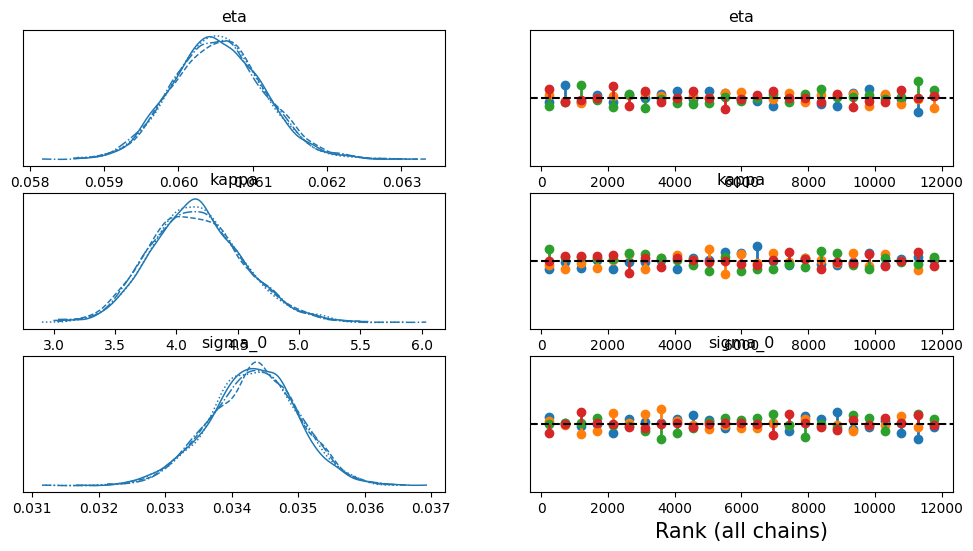

In [6]:
az.plot_trace(idata_lv, kind="rank_vlines");

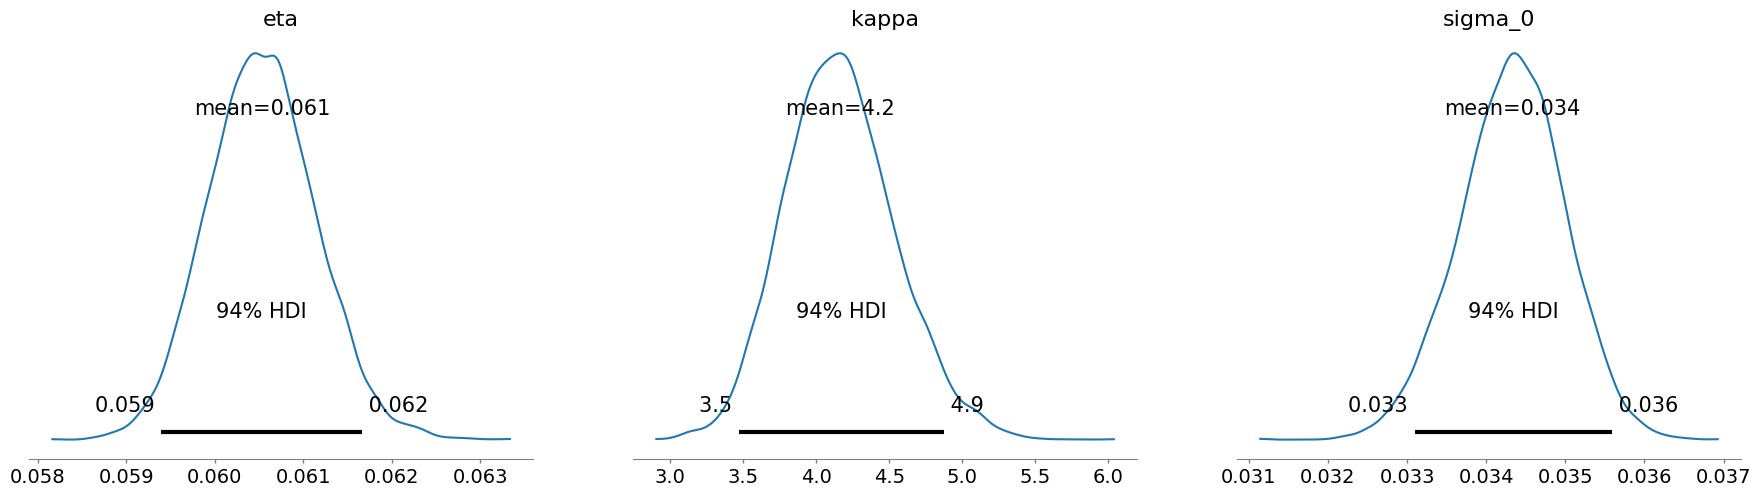

In [7]:
fig = az.plot_posterior(idata_lv);

In [8]:
eta = np.array(pd.DataFrame(idata_lv.posterior.eta)).flatten()
kappa = np.array(pd.DataFrame(idata_lv.posterior.kappa)).flatten()
sigma_0 = np.array(pd.DataFrame(idata_lv.posterior.sigma_0)).flatten()

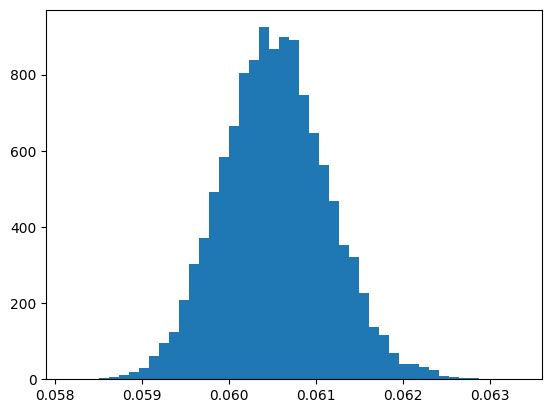

In [10]:
a = plt.hist(eta, bins = 45)

eta_x = (a[1][:-1] + a[1][1:])/2; eta_y = a[0]

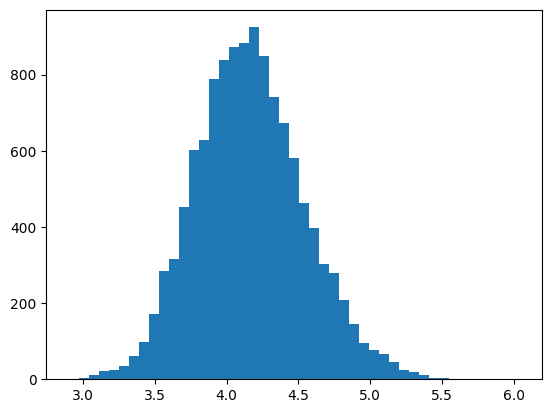

In [11]:
a = plt.hist(kappa, bins = 45)

kappa_x = (a[1][:-1] + a[1][1:])/2; kappa_y = a[0]

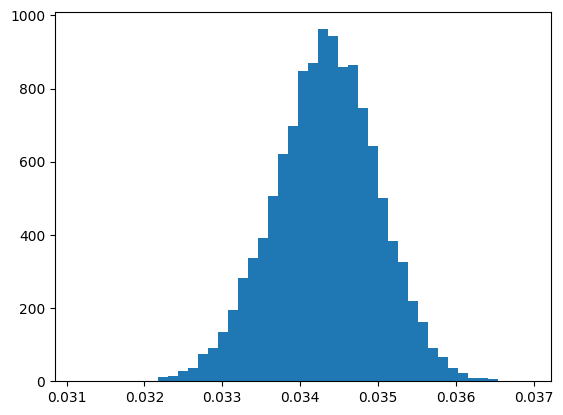

In [12]:
a = plt.hist(sigma_0, bins = 45)

sigma_0_x = (a[1][:-1] + a[1][1:])/2; sigma_0_y = a[0]

In [13]:
N = 64; L = 12;

r = iD.r(maturities); q = iD.q(maturities);
n = len(maturities); m = len(K);

options_type = np.ones(m)
price_matrix = np.zeros([n,m]); true_price = np.zeros([n,m]);
options_type[K < S0] = 0

for i in range(n):
    tau = maturities[i]
    for j in range(m):
        if options_type[j]:
            true_price[i,j] = bs.BSCall(S0, K[j], tau, r[i], q[i], IV[i,j])
        else:
            true_price[i,j] = bs.BSPut(S0, K[j], tau, r[i], q[i], IV[i,j])
            
true_price = true_price.flatten()

In [14]:
def f(rng, eta, kappa, theta, rho, sigma_0, size = None):
    p = np.zeros(n*m)
    for i in range(n):
        tau = maturities[i]
        precomp_term, a, b = Heston.precomputed_terms(r[i], q[i], tau, sigma_0, kappa, eta, theta, rho, L, N)
        p[i*m:(i+1)*m] = Heston.cos_method_Heston_LF(precomp_term, a, b, tau, r[i], q[i], sigma_0, kappa, eta, theta, rho, 
                                       S0, K, N, options_type, L=12)
    return p

In [15]:
start_time = time.time()

with pm.Model() as model_lv:
    
    eta = pm.Interpolated("eta", eta_x, eta_y)
    kappa = pm.Interpolated("kappa", kappa_x, kappa_y)
    sigma_0 = pm.Interpolated("sigma_0", sigma_0_x, sigma_0_y)
    
    theta = pm.Uniform("theta", lower = 0.5, upper = 3)
    rho = pm.Uniform("rho", lower = -1, upper = -1e-4)

    sim = pm.Simulator("sim", f, params = (eta, kappa, theta, rho, sigma_0), epsilon = 10, observed = true_price)

    idata_lv = pm.sample_smc(draws = 2000, chains = 4, progressbar=False)
    
print(f'Elapsed time: {time.time()-start_time: .2f}s')

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Elapsed time:  13691.49s


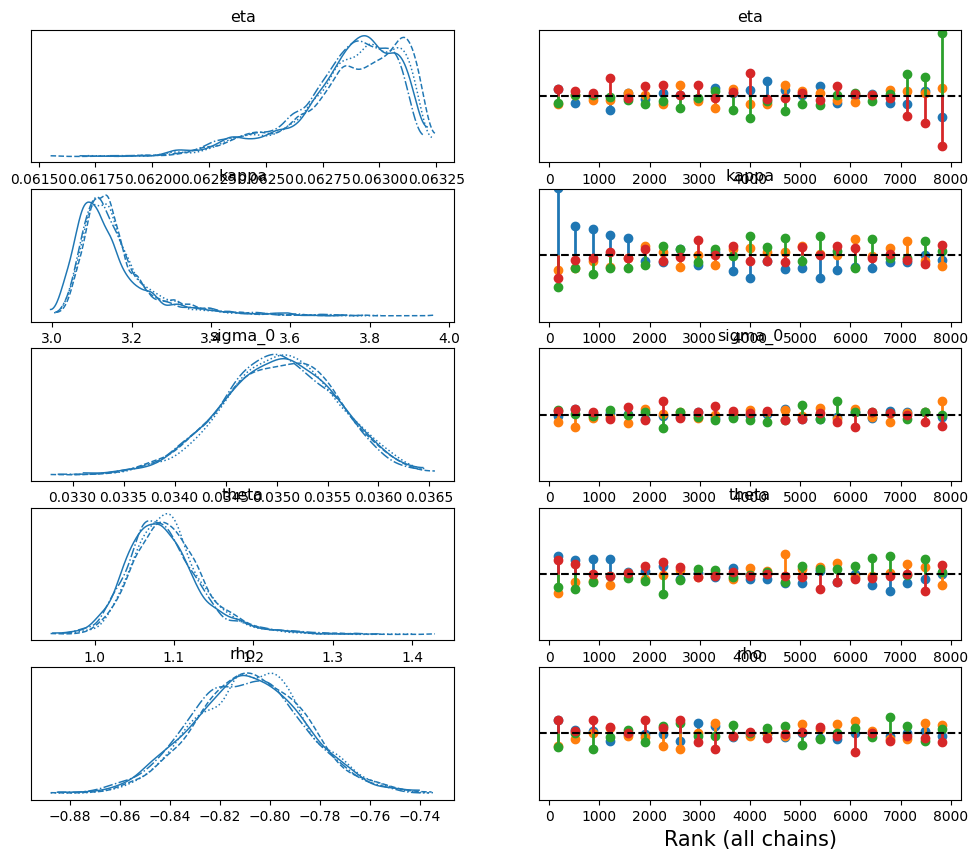

In [16]:
az.plot_trace(idata_lv, kind="rank_vlines");

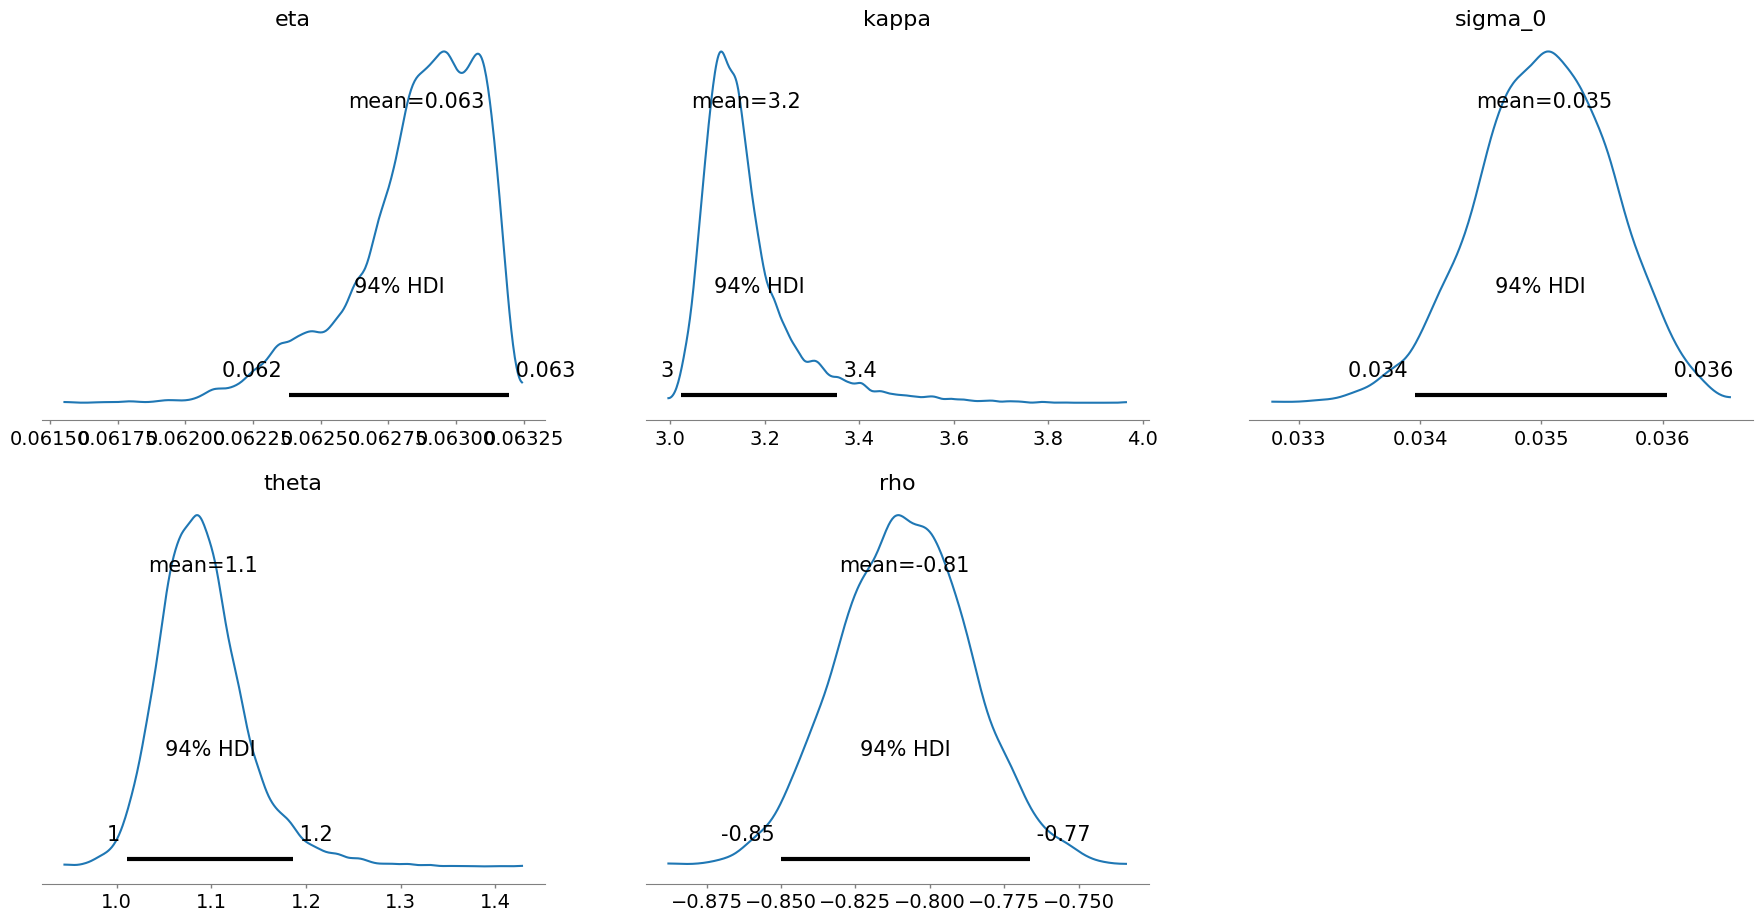

In [17]:
az.plot_posterior(idata_lv);

In [18]:
eta = np.array(pd.DataFrame(idata_lv.posterior.eta)).flatten()
kappa = np.array(pd.DataFrame(idata_lv.posterior.kappa)).flatten()
theta = np.array(pd.DataFrame(idata_lv.posterior.theta)).flatten()
rho = np.array(pd.DataFrame(idata_lv.posterior.rho)).flatten()
sigma_0 = np.array(pd.DataFrame(idata_lv.posterior.sigma_0)).flatten()

Eta: 0.06297461024979689


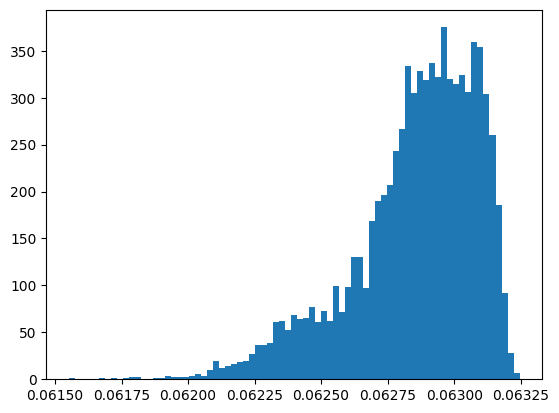

In [19]:
a = plt.hist(eta, bins = 75)

x = (a[1][:-1] + a[1][1:])/2; y = a[0]
x_max = (x[np.argmax(y)]+x[np.argmax(y)+1])/2
print("Eta:",x_max)

Kappa: 3.111291551927008


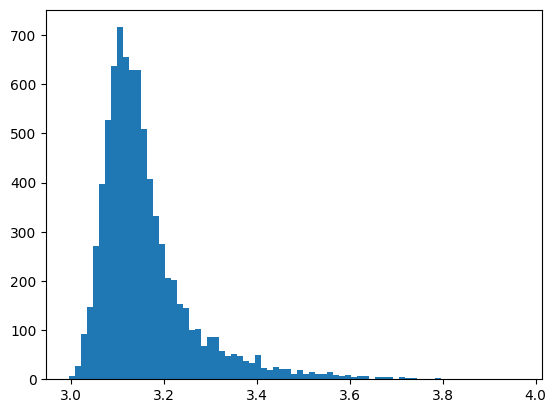

In [20]:
a = plt.hist(kappa, bins = 75)

x = (a[1][:-1] + a[1][1:])/2; y = a[0]
x_max = (x[np.argmax(y)]+x[np.argmax(y)+1])/2
print("Kappa:", x_max)

Theta: 1.0864083431517277


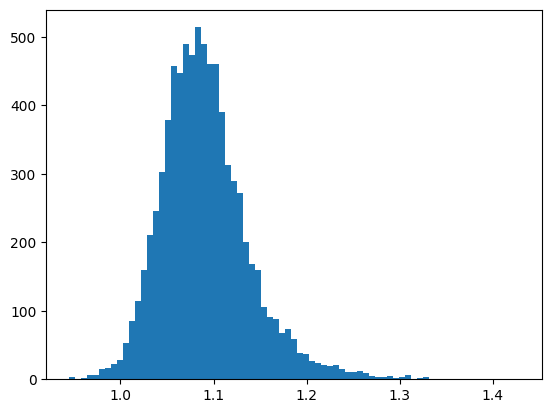

In [21]:
a = plt.hist(theta, bins = 75)

x = (a[1][:-1] + a[1][1:])/2; y = a[0]
x_max = (x[np.argmax(y)]+x[np.argmax(y)+1])/2
print("Theta:", x_max)

Rho: -0.8099208981919184


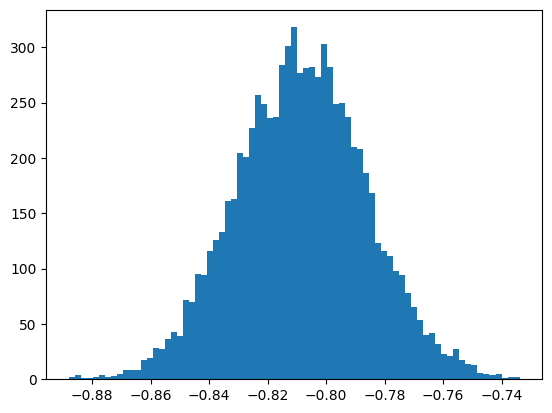

In [22]:
a = plt.hist(rho, bins = 75)

x = (a[1][:-1] + a[1][1:])/2; y = a[0]
x_max = (x[np.argmax(y)]+x[np.argmax(y)+1])/2
print("Rho:", x_max)

Sigma: 0.03504626144419665


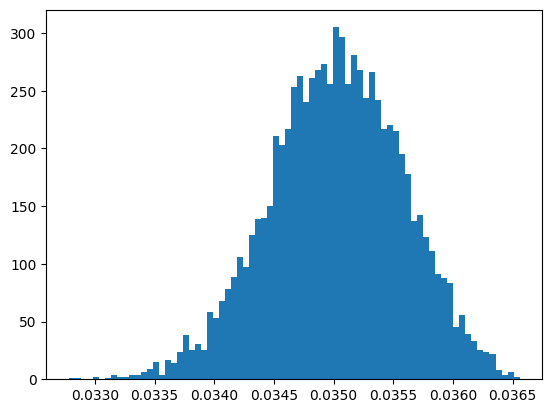

In [23]:
a = plt.hist(sigma_0, bins = 75)

x = (a[1][:-1] + a[1][1:])/2; y = a[0]
x_max = (x[np.argmax(y)]+x[np.argmax(y)+1])/2
print("Sigma:", x_max)

In [24]:
data = pd.concat([pd.DataFrame(rho, columns = ["rho"]), pd.DataFrame(theta, columns = ["theta"])], axis = 1)
data = pd.concat([data, pd.DataFrame(kappa, columns = ["kappa"])], axis = 1)
data = pd.concat([data, pd.DataFrame(eta, columns = ["eta"])], axis = 1)
data = pd.concat([data, pd.DataFrame(sigma_0, columns = ["sigma_0"])], axis = 1)
data.to_csv("Heston_data.csv", index = False)